In [17]:
#Classe per salvare nome e valore delle varie misure
class ValMeasures(object):
    def __init__(self, measure_name, value):
        self.measure_name = measure_name
        self.value = value
        
    def getMeasure(self):
        return self.measure_name
    def getValue(self):
        return self.value
        

In [18]:
s_map = "map"
s_rprec = "Rprec"
s_pten = "P_10"

#metodo per estrarre i valori delle misure richieste da un file .txt
def extract_measures(valuations_file):
    topic_valuations = {}
    for line in open(valuations_file,"r"):
        word = line.split()
        if((word[0] == s_map) | (word[0] == s_rprec) | (word[0] == s_pten)):
            topic = word[1]
            if (topic not in topic_valuations):
                #define new term in dictionary
                topic_valuations[topic] = [ValMeasures(word[0],word[2])]
            else:
                topic_valuations[topic].append(ValMeasures(word[0],word[2]))
    return topic_valuations


        


In [19]:
#metodo per salvare i valori estratti da un file in array
def values_list(list_top_val):
    x = []
    y_map = []
    y_rprec = []
    y_pten = []
    for topic in list_top_val:
        if(topic != 'all'):
            x.append(topic)
            y_map.append(float(list_top_val[topic][0].getValue()))
            y_rprec.append(float(list_top_val[topic][1].getValue()))
            y_pten.append(float(list_top_val[topic][2].getValue()))
    return x, y_map, y_rprec, y_pten

    

In [20]:
#metodo per stampare un Istogramma con i valori delle varie run per ogni topic
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
def plot4Histograms(title, x_label, y_label, vals1, vals2, vals3, vals4, width, topics):
    l1 ='TFIDF with Stopwords & PorterStemmer'
    l2 = 'TFIDF'
    l3 = 'BM25 with Stopwords & PorterStemmer'
    l4 = 'BM25 with PorterStemmer'
    indx = np.arange(len(vals1))
    
    fig, ax = plt.subplots()
    fig_size = plt.rcParams['figure.figsize']
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams['figure.figsize'] = fig_size
    
    rects1 = ax.bar(indx -3*(width/2), vals1, width, color='ForestGreen', label=l1)
    rects2 = ax.bar(indx -width/2, vals2, width, color='SkyBlue', label=l2)
    rects3 = ax.bar(indx +width/2, vals3, width, color= 'IndianRed',label=l3)
    rects4 = ax.bar(indx +3*(width/2), vals4, width, color='DarkOrange',label=l4)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(indx)
    ax.set_xticklabels(topics)
    
    ax.legend()
    
    plt.show()

In [21]:
#metodo per eseguire il testo statistico ANOVA 1-way
import pandas as pd
import scipy.stats
def anova1way(val1,val2,val3,val4):
    system_val = []
    error_val = []
    t_run1 = np.sum(np.power(val1,2))
    t_run2 = np.sum(np.power(val2,2))
    t_run3 = np.sum(np.power(val3,2))
    t_run4 = np.sum(np.power(val4,2))
    T = t_run1 + t_run2 + t_run3 + t_run4

    n_run1 = len(val1)
    n_run2 = len(val2)
    n_run3 = len(val3)
    n_run4 = len(val4)
    N = n_run1 + n_run2 + n_run3 + n_run4
    K = 4
    tot_sum_2 = np.power((np.sum(val1)+np.sum(val2)+np.sum(val3)+np.sum(val4)),2)
    ss_total = T - (tot_sum_2/N)
    #ss_system = (t_run1/n_run1 + t_run2/n_run2 + t_run3/n_run3 + t_run4/n_run4) - tot_sum_2/N
    ss_system = (np.power(np.sum(val1),2)/n_run1 + np.power(np.sum(val2),2)/n_run2 + np.power(np.sum(val3),2)/n_run3 + np.power(np.sum(val4),2)/n_run4) - tot_sum_2/N
    ss_error = ss_total - ss_system
    

    df_system = K -1
    df_error = N - K
    df_total = N - 1

    ms_system = ss_system / df_system
    ms_error = ss_error / df_error

    F = ms_system / ms_error
    p_value = scipy.stats.f.sf(F, df_system, df_error)
    
    dec_counted = 6
    '''data = np.array([['','SS','DF','MS','F','Prob>F'],
                ['Systems',ss_system,df_system,ms_system,F,p_value],
                ['Error',ss_error,df_error,ms_error,'---','---'],
                ['Total',ss_total,df_total,'---','---','---']])'''
    data = np.array([['','SS','DF','MS','F','Prob>F'],
                ['Systems',round(ss_system,dec_counted),df_system,round(ms_system,dec_counted),round(F,dec_counted),round(p_value,dec_counted)],
                ['Error',round(ss_error,dec_counted),df_error,round(ms_error,dec_counted),'---','---'],
                ['Total',round(ss_total,dec_counted),df_total,'---','---','---']])
                
    print(pd.DataFrame(data=data[1:,1:],
                  index=data[1:,0],
                  columns=data[0,1:]))

In [22]:
#Metodo per eseguire il test TUKEY HSD
from statsmodels.stats.multicomp import MultiComparison
from operator import itemgetter
def tukeyHSD_test(measure,val1,val2,val3,val4,sys,alpha):
    data = np.concatenate([val1,val2,val3,val4])
    mc = MultiComparison(data,sys)
    result = mc.tukeyhsd(alpha)
    print(result.summary())
    
    runs = [('Run1',np.mean(val1)),('Run2',np.mean(val2)),
            ('Run3',np.mean(val3)),('Run4',np.mean(val4))]
    
    best_run = max(runs,key=itemgetter(1))[0]
    
    result.plot_simultaneous(comparison_name=best_run,xlabel=measure,ylabel='RUN')
    

In [23]:
topic_valuations_tfidf0 = extract_measures("models_results/val_tip2/valRun1.txt")
tfidf0_x, tfidf0_map, tfidf0_rprec, tfidf0_pten = values_list(topic_valuations_tfidf0)

topic_valuations_tfidf1 = "models_results/val_tip2/valRun2.txt"
tfidf1_x, tfidf1_map, tfidf1_rprec, tfidf1_pten = values_list(topic_valuations_tfidf0)

topic_valuations_bm25_2 = extract_measures("models_results/val_tip2/valRun3.txt")
bm25_2_x, bm25_2_map, bm25_2_rprec, bm25_2_pten = values_list(topic_valuations_bm25_2)

topic_valuations_bm25_3 = extract_measures("models_results/val_tip2/valRun4.txt")
bm25_3_x, bm25_3_map, bm25_3_rprec, bm25_3_pten = values_list(topic_valuations_bm25_3)

alpha = 0.05
sys = []
for i in range(1,5):
    for x in tfidf0_map:
        sys.append('Run'+str(i))

<h1>Valuations on AP results</h1>

{'whiskers': [<matplotlib.lines.Line2D at 0x1a17d147b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a17d14e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a17d14668>,
 'medians': [<matplotlib.lines.Line2D at 0x1a1820c518>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1820c860>,
 'means': []}

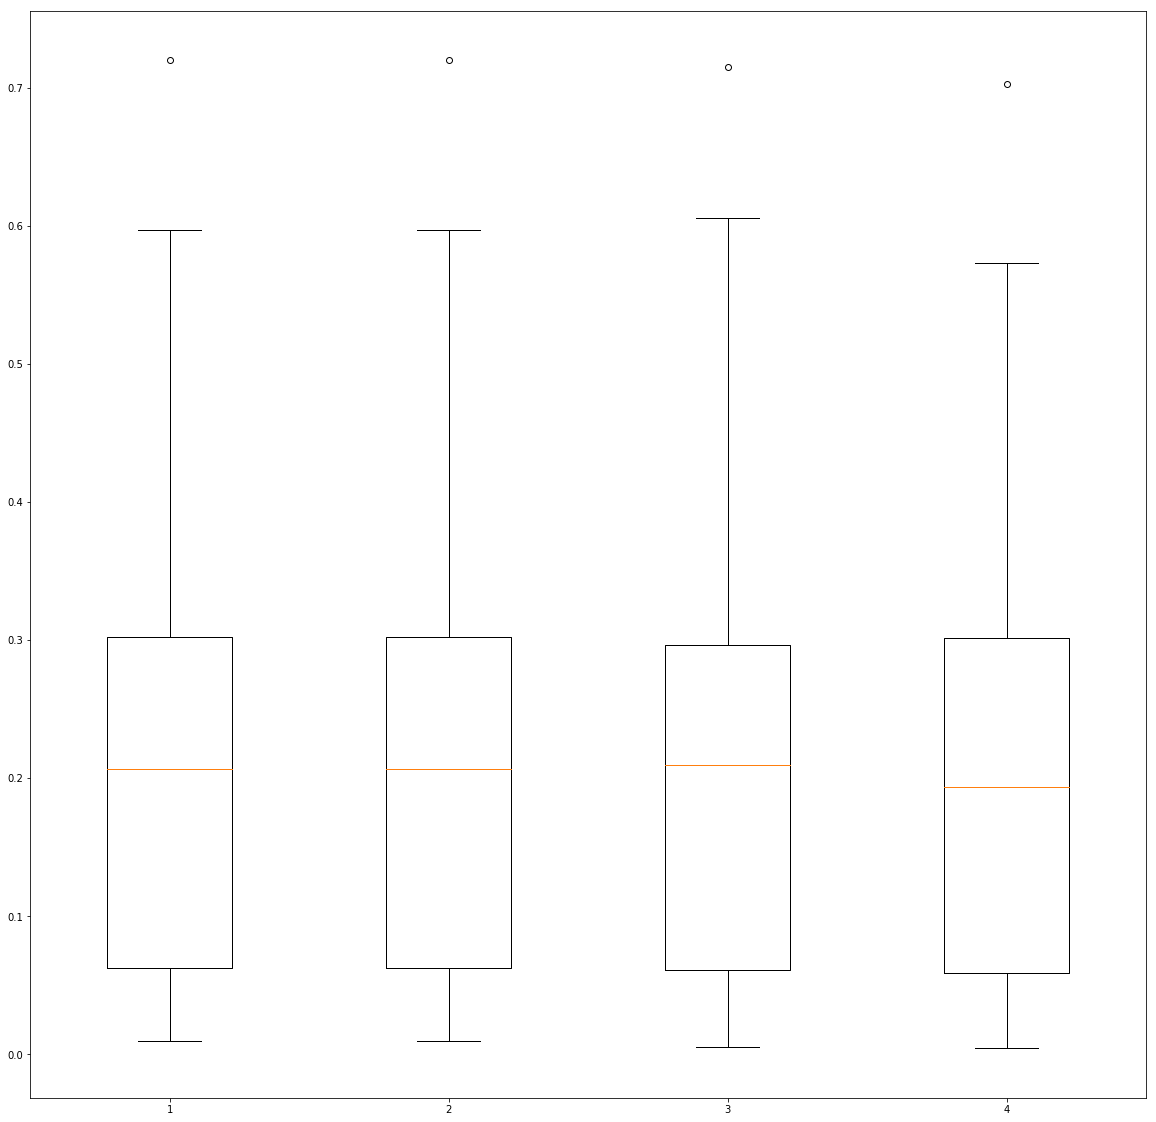

In [31]:
#Stampo il boxplot delle varie run per l'Average Precision
data = [tfidf0_map, tfidf1_map, bm25_2_map, bm25_3_map]
fig7, ax7 = plt.subplots()
ax7.boxplot(data)

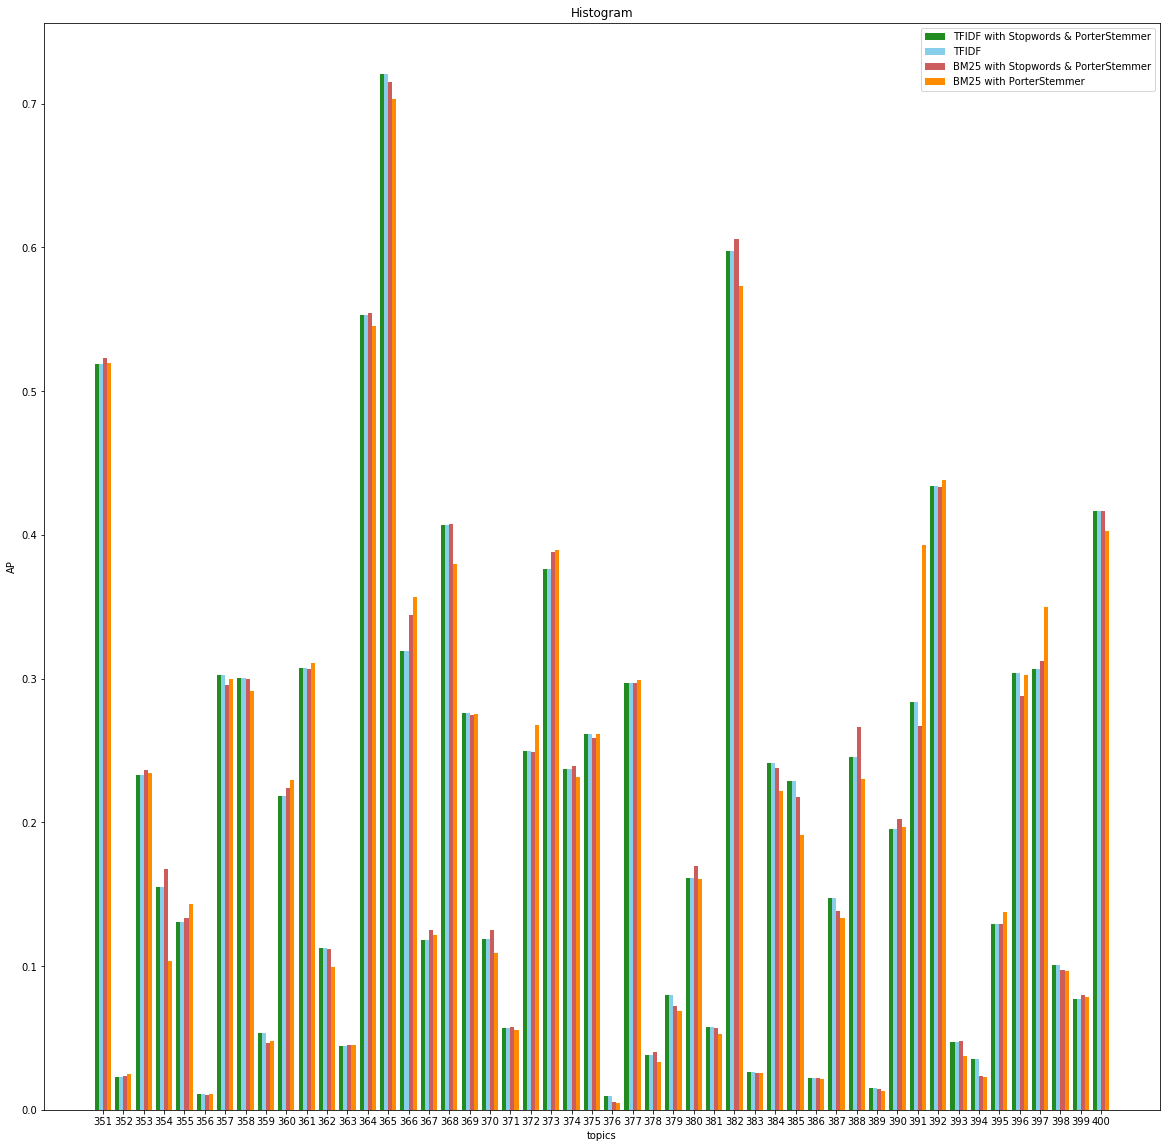

In [32]:
plot4Histograms('Histogram','topics', 'AP', tfidf0_map,tfidf1_map,bm25_2_map,bm25_3_map,0.2,tfidf0_x)

               SS   DF        MS         F    Prob>F
Systems   8.3e-05    3   2.8e-05  0.000982  0.999957
Error     5.51112  196  0.028118       ---       ---
Total    5.511203  199       ---       ---       ---




Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2    0.0    -0.0869 0.0869 False 
 Run1   Run3   0.0005  -0.0864 0.0874 False 
 Run1   Run4  -0.0012  -0.0881 0.0857 False 
 Run2   Run3   0.0005  -0.0864 0.0874 False 
 Run2   Run4  -0.0012  -0.0881 0.0857 False 
 Run3   Run4  -0.0018  -0.0887 0.0852 False 
--------------------------------------------


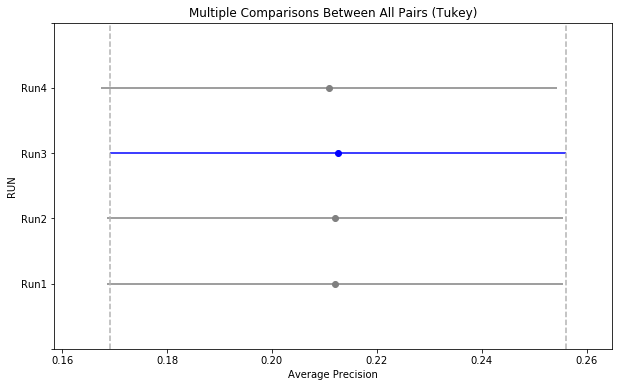

In [33]:
anova1way(tfidf0_map,tfidf1_map,bm25_2_map,bm25_3_map)
print('\n\n\n')
tukeyHSD_test('Average Precision',tfidf0_map,tfidf1_map,bm25_2_map,bm25_3_map,sys,alpha)

<h1>Valuations on P@10 results</h1>

{'whiskers': [<matplotlib.lines.Line2D at 0x1a15e8a4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a15e8ab70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a15e8a390>,
 'medians': [<matplotlib.lines.Line2D at 0x1a16078240>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a16078588>,
 'means': []}

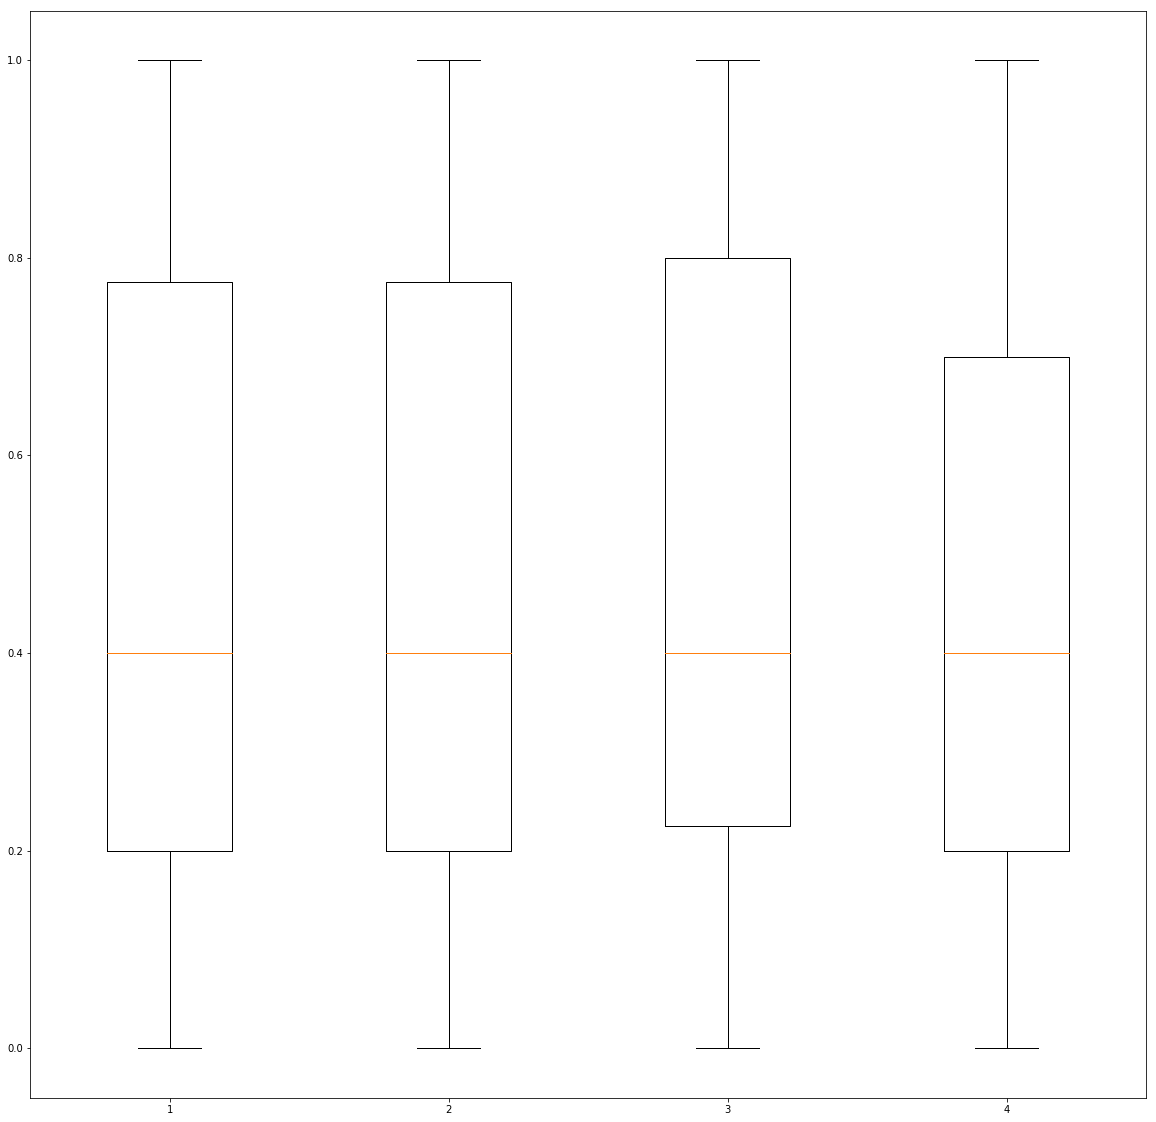

In [34]:
#Stampo il boxplot delle varie run per il Precision at 10
data = [tfidf0_pten, tfidf1_pten, bm25_2_pten, bm25_3_pten]
fig7, ax7 = plt.subplots()
ax7.boxplot(data)

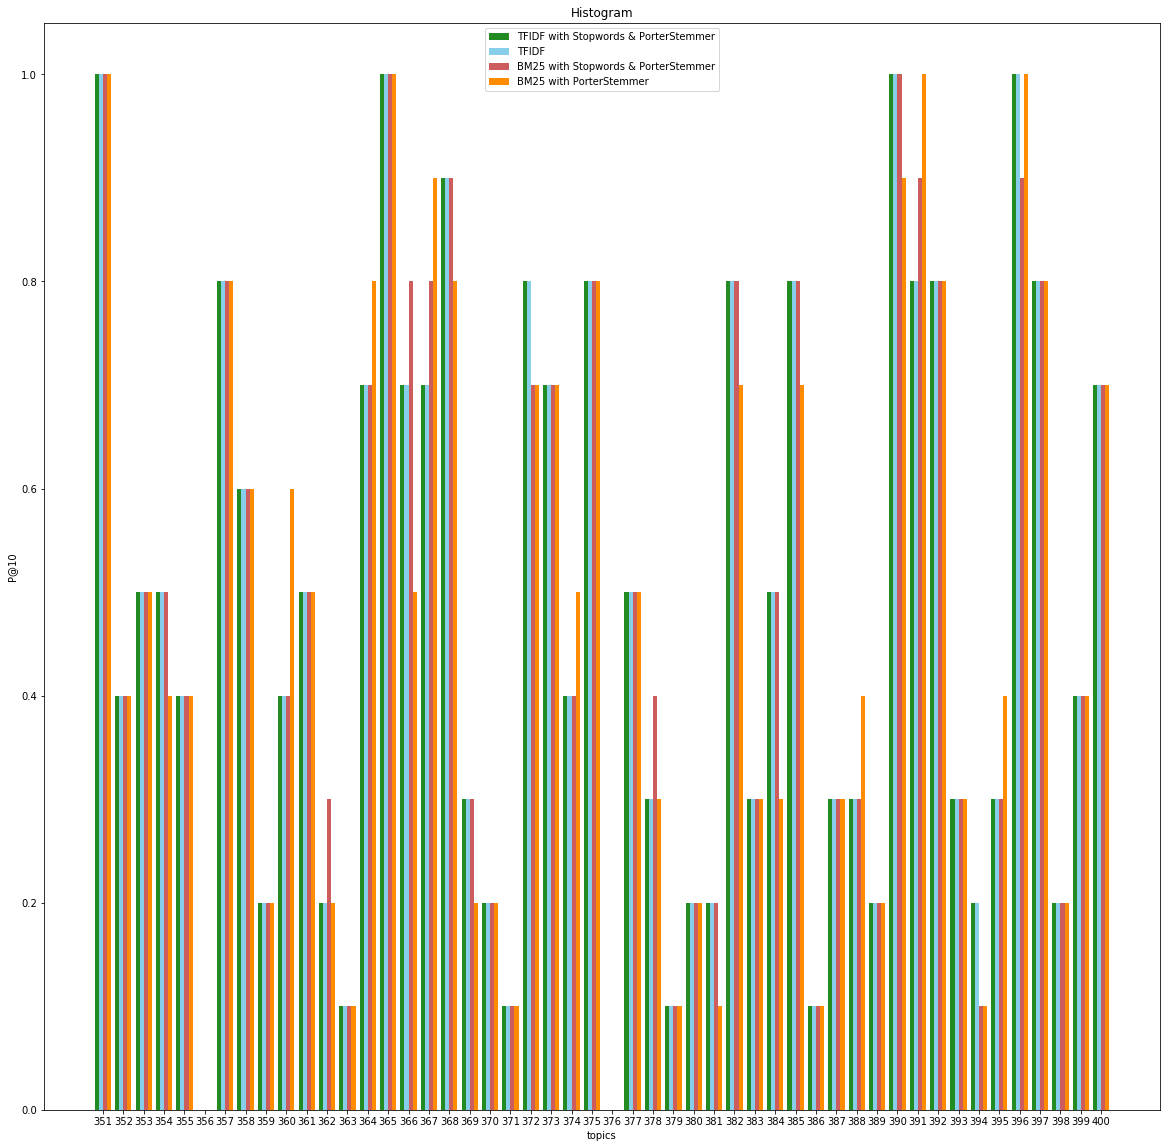

In [35]:
plot4Histograms('Histogram','topics', 'P@10', tfidf0_pten,tfidf1_pten,bm25_2_pten,bm25_3_pten,0.2,tfidf0_x)

               SS   DF        MS         F   Prob>F
Systems   0.00255    3   0.00085  0.009684  0.99869
Error     17.2034  196  0.087772       ---      ---
Total    17.20595  199       ---       ---      ---




Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2    0.0    -0.1535 0.1535 False 
 Run1   Run3   0.004   -0.1495 0.1575 False 
 Run1   Run4   -0.006  -0.1595 0.1475 False 
 Run2   Run3   0.004   -0.1495 0.1575 False 
 Run2   Run4   -0.006  -0.1595 0.1475 False 
 Run3   Run4   -0.01   -0.1635 0.1435 False 
--------------------------------------------


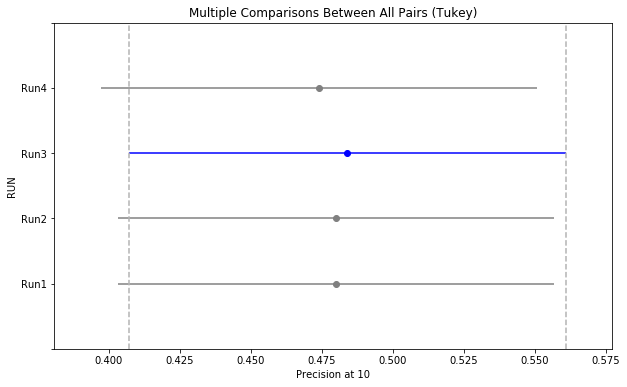

In [36]:
anova1way(tfidf0_pten,tfidf1_pten,bm25_2_pten,bm25_3_pten)
print('\n\n\n')
tukeyHSD_test('Precision at 10',tfidf0_pten,tfidf1_pten,bm25_2_pten,bm25_3_pten,sys,alpha)

<h1>Valuations on RPREC results</h1>

{'whiskers': [<matplotlib.lines.Line2D at 0x1a19a140f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a19a14780>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a19a0ef60>,
 'medians': [<matplotlib.lines.Line2D at 0x1a19a14e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a19a1d198>,
 'means': []}

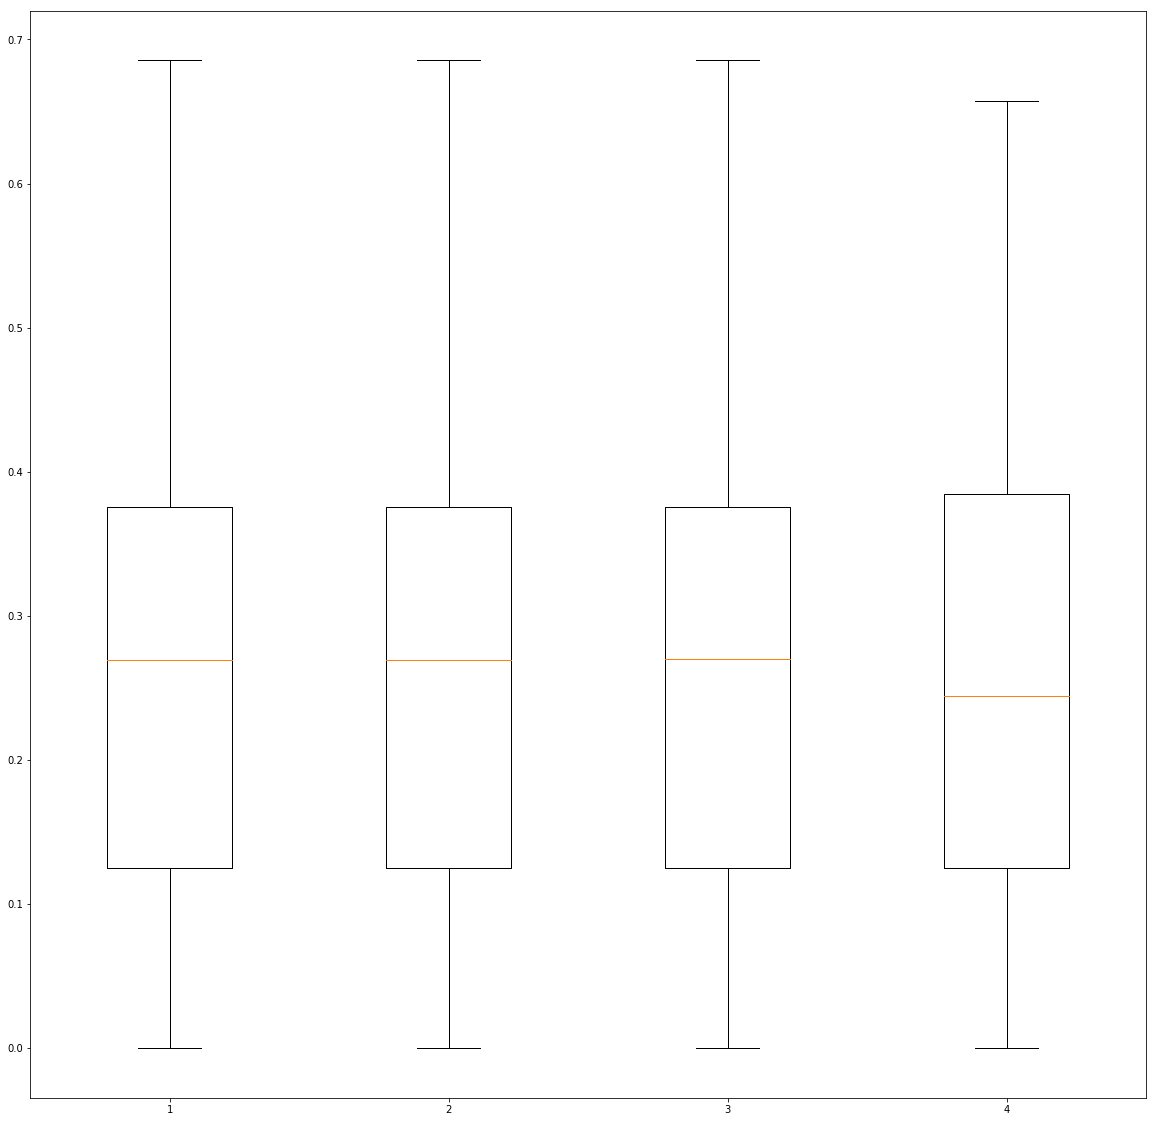

In [37]:
#Stampo il boxplot delle varie run per l'RPREC
data = [tfidf0_rprec, tfidf1_rprec, bm25_2_rprec, bm25_3_rprec]
fig7, ax7 = plt.subplots()
ax7.boxplot(data)

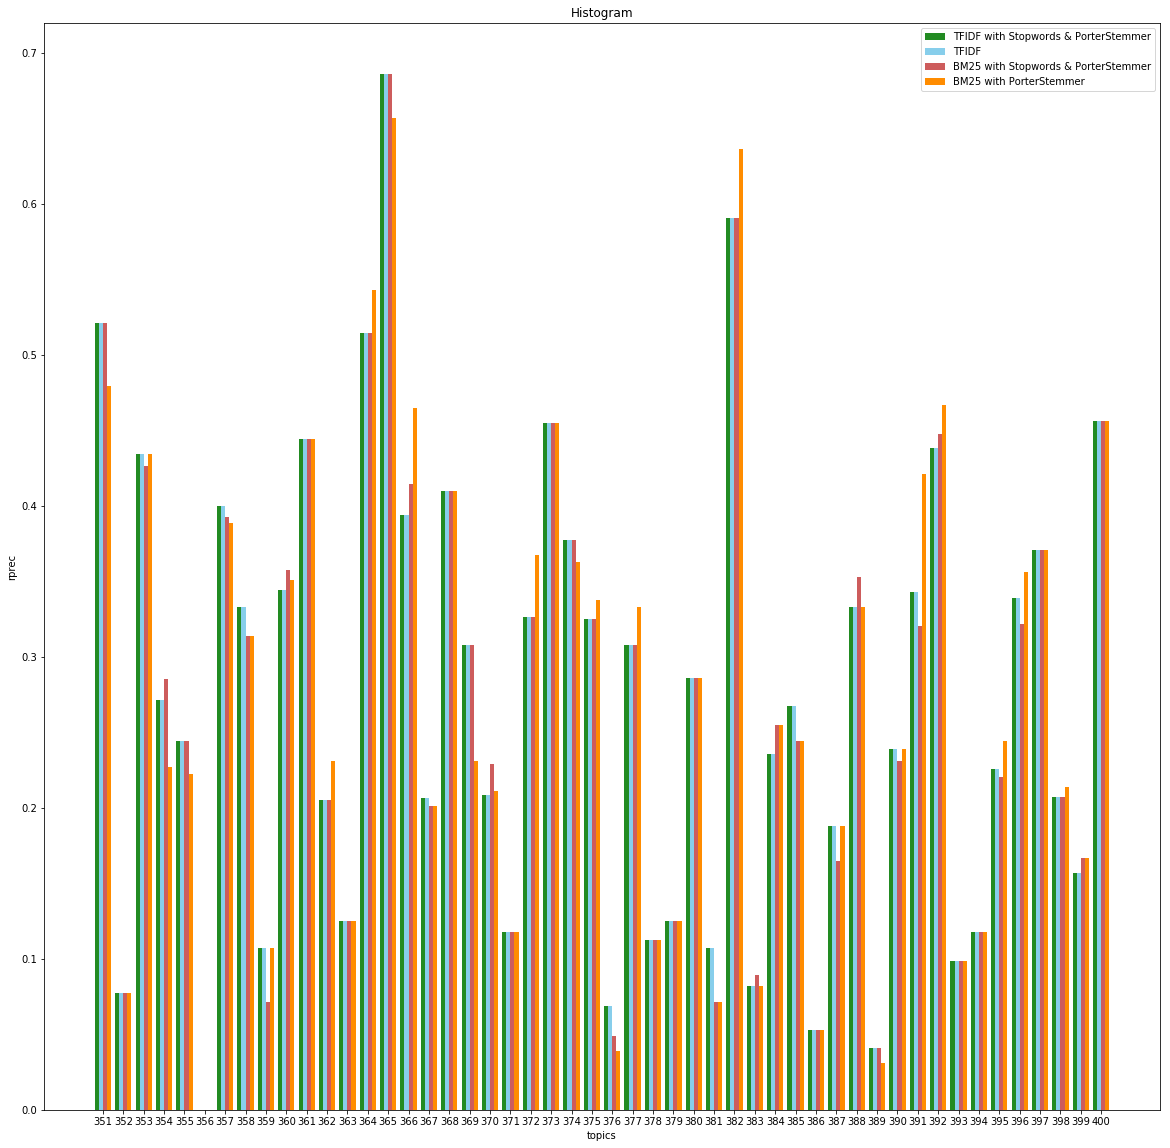

In [38]:
plot4Histograms('Histogram','topics', 'rprec', tfidf0_rprec,tfidf1_rprec,bm25_2_rprec,bm25_3_rprec,0.2,tfidf0_x)

               SS   DF       MS         F    Prob>F
Systems  0.000296    3  9.9e-05  0.003997  0.999651
Error    4.845107  196  0.02472       ---       ---
Total    4.845404  199      ---       ---       ---




Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2    0.0    -0.0815 0.0815 False 
 Run1   Run3  -0.0019  -0.0834 0.0796 False 
 Run1   Run4   0.0015   -0.08  0.083  False 
 Run2   Run3  -0.0019  -0.0834 0.0796 False 
 Run2   Run4   0.0015   -0.08  0.083  False 
 Run3   Run4   0.0034  -0.0781 0.0849 False 
--------------------------------------------


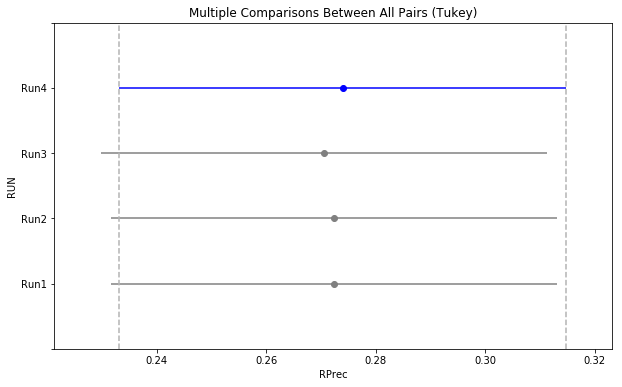

In [39]:
anova1way(tfidf0_rprec,tfidf1_rprec,bm25_2_rprec,bm25_3_rprec)
print('\n\n\n')
tukeyHSD_test('RPrec',tfidf0_rprec,tfidf1_rprec,bm25_2_rprec,bm25_3_rprec,sys,alpha)